**Imports**

In [23]:
"""
IMPORTS
"""
import numpy as np 
import matplotlib.pyplot as plt
import random
import math
import statistics
from scipy import stats
import astropy
import astropy.io.fits as fits
from photutils.centroids import centroid_1dg, centroid_2dg, centroid_quadratic, centroid_com
from photutils.centroids import centroid_sources
import scipy.constants as constant
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from os import listdir
from os.path import isfile, join
from datetime import datetime
from glob import glob
from pathlib import Path
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord 
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
from scipy.optimize import curve_fit
from decimal import Decimal
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings("ignore", category=astropy.wcs.FITSFixedWarning)

**Photometric Analysis and Calibration**

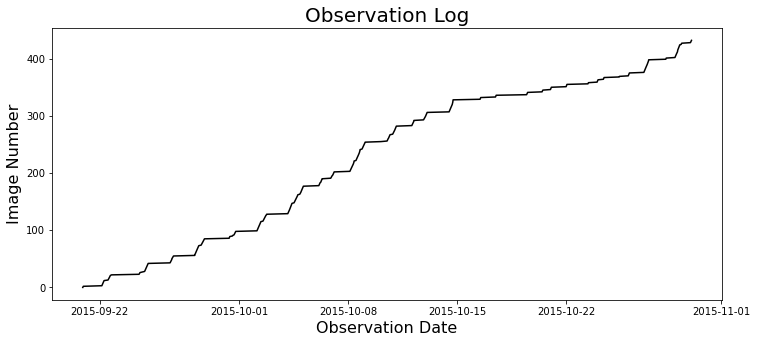

In [4]:
img_folder = Path('C:/Users/aliah/Desktop/AST325 H1F/Lab 3/img_data/')
file_names = [f for f in listdir('C:/Users/aliah/Desktop/AST325 H1F/Lab 3/img_data/') if isfile(join('C:/Users/aliah/Desktop/AST325 H1F/Lab 3/img_data/', f)) and 'fits' in f]
file_times = []
for f in file_names:
    header = fits.open(img_folder / f)[0].header
    dt = datetime.fromisoformat(header["DATE-OBS"])
    file_times.append(dt)

#sort files by the same way
file_times, file_names = zip(*sorted(zip(file_times, file_names)))

file_names = np.array(file_names)
file_times = np.array(file_times)

plt.figure(figsize=(12,5))
plt.plot(file_times, np.arange(file_times.size), color = 'k')
plt.ylabel("Image Number", size = 16)
plt.xlabel("Observation Date", size = 16)
plt.title("Observation Log", size = 20)
plt.savefig('Lab3_ObservationPlot' + '.png', bbox_inches='tight', dpi=400)
plt.show()

In [5]:
def read_file(filename):
    hdu = fits.open(img_folder/filename)[0]
    #Convert to 32bit int
    data = hdu.data.astype(int)
    #Try and reverse the overflow for values less than -1000
    data[data < -1e3] = ((2**15-1)-np.abs(data[data < -1e3])) + (2**15-1)
    return data

def plot_image(filename):
    data1 = read_file(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(data1,
               vmin = -100,
               vmax = 100,
               origin = 'lower',
               cmap = 'viridis')
    plt.show()

bad_examples = ['AST325-326-SN-20150924.7465.fits','AST325-326-SN-20150930.5694.fits',
'AST325-326-SN-20150930.6694.fits','AST325-326-SN-20151004.6194.fits',
'AST325-326-SN-20151006.9146.fits', 'AST325-326-SN-20151008.9813.fits',
'AST325-326-SN-20151004.5653.fits', 'AST325-326-SN-20151004.8792.fits',
'AST325-326-SN-20151008.9597.fits', 'AST325-326-SN-20151026.0403.fits', 
'AST325-326-SN-20151026.0549.fits', 'AST325-326-SN-20151012.8410.fits',
'AST325-326-SN-20151012.8410.fits', 'AST325-326-SN-20151004.6354.fits', 
'AST325-326-SN-20151010.8764.fits','AST325-326-SN-20151011.0174.fits', 
'AST325-326-SN-20151011.0479.fits', 'AST325-326-SN-20151017.4861.fits',
'AST325-326-SN-20151029.4160.fits']

#for f in examples:
    #print(img_folder/f)
    #plot_image(img_folder/f)

In [58]:
med_val = []
for i in range(len(file_names)):
    img = fits.open(img_folder / file_names[i])[0].data
    med = np.median(img[1125-5:1125+5, 1125-5:1125+5], axis=0)
    med_val.append(med)

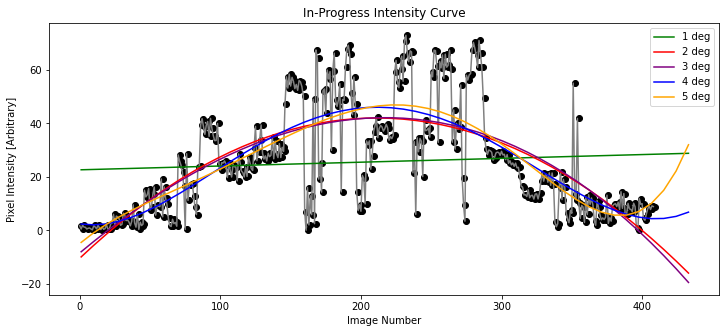

In [59]:
max_med = []
for i in med_val:
    max_med.append(np.mean(i))
    
#print(max_med)
#print('/n')
elements = np.array(max_med)

mean = np.mean(elements, axis=0)
sd = np.std(elements, axis=0)

final_list = [x for x in max_med if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
final_list = [x for x in final_list if (x > 0)]
#print(final_list)
c = 409
x = list(np.arange(1,c+1))

#fit polynomial models up to degree 5
model1 = np.poly1d(np.polyfit(x, final_list, 1))
model2 = np.poly1d(np.polyfit(x, final_list, 2))
model3 = np.poly1d(np.polyfit(x, final_list, 3))
model4 = np.poly1d(np.polyfit(x, final_list, 4))
model5 = np.poly1d(np.polyfit(x, final_list, 5))

plt.figure(figsize = (12,5))

#create scatterplot
polyline = np.linspace(1, 433, 50)
plt.plot(final_list, color='gray')
plt.scatter(x, final_list, color='black')

#add fitted polynomial lines to scatterplot 
plt.plot(polyline, model1(polyline), color='green', label='1 deg')
plt.plot(polyline, model2(polyline), color='red', label='2 deg')
plt.plot(polyline, model3(polyline), color='purple', label='3 deg')
plt.plot(polyline, model4(polyline), color='blue', label='4 deg')
plt.plot(polyline, model5(polyline), color='orange', label='5 deg')

plt.ylabel("Pixel Intensity [Arbitrary]")
plt.xlabel("Image Number")
plt.title("In-Progress Intensity Curve")
plt.legend()
plt.savefig('Lab3_inprogress_LC' + '.png', bbox_inches='tight', dpi=400)
plt.show()

**Defining Postions of AST325-326-SN & Reference Stars**

In [6]:
#Pixel positions of the refernce stars
header = fits.open(img_folder/file_names[0])[0].header
img = read_file(file_names[0])
w = WCS(header)

#(RA, DEC) = (00:57:03.19, -37:02:23.6) 
sn_RD = SkyCoord('00h57m03.19s', '-37d02m23.06s')
sn_pos = skycoord_to_pixel(sn_RD, w)
print('AST325-326-SN pixel position: (x,y) = ', sn_pos[0], sn_pos[1])

#(RA, DEC) = (00:56:49.70, -37:01:38.31) 
ref1_RD = SkyCoord('00h56m49.70s', '-37d01m38.31s')
ref1_pos = skycoord_to_pixel(ref1_RD, w)
print('Reference Star 1 pixel position: (x,y) = ', ref1_pos[0], ref1_pos[1])

#(RA, DEC) = (00:56:46.43, -37:02:29.50) 
ref2_RD = SkyCoord('00h56m46.43s', '-37d02m29.50s')
ref2_pos = skycoord_to_pixel(ref2_RD, w)
print('Reference Star 2 pixel position: (x,y) = ', ref2_pos[0], ref2_pos[1])

#((RA, DEC) = (00:56:58.27, -36:58:16.60) 
ref3_RD = SkyCoord('00h56m58.27s', '-36d58m16.60s')
ref3_pos = skycoord_to_pixel(ref3_RD, w)
print('Reference Star 3 pixel position: (x,y) = ', ref3_pos[0], ref3_pos[1])

#good_files = []

AST325-326-SN pixel position: (x,y) =  1125.372972509371 1126.1176219162958
Reference Star 1 pixel position: (x,y) =  1532.7993922131423 1242.2382688284804
Reference Star 2 pixel position: (x,y) =  1634.05217782159 1114.3214862524105
Reference Star 3 pixel position: (x,y) =  1263.8081526407473 1747.9495848232793


**Defining Centroiding Function**

In [7]:
def Centroid(img, x, y, p=False):
    """
    Takes in a fits file image data and the close/aprox loc of the object (x,y)
    needing to be centorided and returns the mean & error of different centtroiding algorithms.
    Note: if p is True, the centroids will be plotted with image
    """
    data = read_file(img)
    x_init, y_init = x, y
    x1, y1 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_com)
    x2, y2 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_quadratic)
    x3, y3 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_1dg)
    x4, y4 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_2dg)
    xycens = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
        
    if p:
        fig, ax = plt.subplots(1, 1, figsize=(4, 5))
        ax.imshow(data, origin='lower', interpolation='nearest')
        marker = '+'
        ms, mew = 15, 2.
        plt.plot(x1, y1, color='green', marker=marker, ms=ms, mew=mew, label='COM Centroid')
        plt.plot(x2, y2, color='white', marker=marker, ms=ms, mew=mew, label='2D Gaussian Polynomial Centroid')
        plt.plot(x3, y3, color='red', marker=marker, ms=ms, mew=mew, label='1D Gaussian Centroid')
        plt.plot(x4, y4, color='blue', marker=marker, ms=ms, mew=mew, label='2D Gaussian Centroid')
        plt.axis([x-25, x+25, y-25, y+25])
        plt.legend()
        plt.xlabel('Pixel Range X-axis')
        plt.ylabel('Pixel Range Y-axis')
        plt.title('Centroids on specified loation')
        plt.imshow(data, vmin = -100, vmax = 100, origin = 'lower', cmap = 'viridis')
        plt.show()

    avg_x = np.mean([x1,x2,x3,x4])
    avg_y = np.mean([y1,y2,y3,y4])

    #Calculatin the error stdev for the centroid
    dx = np.std([x1,x2,x3,x4])
    dy = np.std([y1,y2,y3,y4])
    
    #print('Centroid X-axis position =', avg_x, "±", dx)
    #print('Centroid Y-axis position =', avg_y, "±", dy)
    #print('Pixel Intensity at Centroid position =', data[int(avg_y.round())][int(avg_x.round())])
    return (avg_x, dx), (avg_y, dy), data[int(avg_y.round())][int(avg_x.round())]

**Testing Centroiding Function on Reference Star(s)**

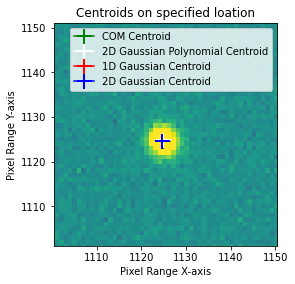

In [7]:
Centroid(file_names[250], sn_pos[0], sn_pos[1], p=True)

test_plot = False
if test_plot:
    data = read_file(file_names[250])
    x, y = sn_pos[0], sn_pos[1]
    x_init, y_init = sn_pos[0], sn_pos[1]
    x1, y1 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_com)
    x2, y2 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_quadratic)
    x3, y3 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_1dg)
    x4, y4 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_2dg)
    xycens = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]

    fig, ax = plt.subplots(1, 1, figsize=(4, 5))
    ax.imshow(data, origin='lower', interpolation='nearest')
    marker = '+'
    ms, mew = 15, 2.
    plt.plot(x1, y1, color='green', marker=marker, ms=ms, mew=mew, label='COM Centroid')
    plt.plot(x2, y2, color='white', marker=marker, ms=ms, mew=mew, label='2D Gaussian Polynomial Centroid')
    plt.plot(x3, y3, color='red', marker=marker, ms=ms, mew=mew, label='1D Gaussian Centroid')
    plt.plot(x4, y4, color='blue', marker=marker, ms=ms, mew=mew, label='2D Gaussian Centroid')
    plt.axis([x-25, x+25, y-25, y+25])
    plt.legend()
    plt.xlabel('Pixel Range X-axis')
    plt.ylabel('Pixel Range Y-axis')
    plt.title('Centroids on specified loation')
    plt.imshow(data, vmin = -100, vmax = 100, origin = 'lower', cmap = 'viridis')
    plt.savefig('Lab3_CentroidTest' + '.png', bbox_inches='tight', dpi=400)
    plt.show()

**Filtering Images Via The Centroiding Function**

In [250]:
for i in range(len(file_names)):    
    data = read_file(file_names[i])
    a = True
    b = True
    c = True
    
    x_init, y_init = ref1_pos[0], ref1_pos[1]
    x1, y1 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_com)
    x2, y2 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_quadratic)
    x3, y3 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_1dg)
    x4, y4 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_2dg)
    avg_x = np.mean([x1,x2,x3,x4])
    avg_y = np.mean([y1,y2,y3,y4])
    if np.isnan(x1, y1).any() or np.isnan(x2, y2).any() or np.isnan(x3, y3).any() or np.isnan(x4, y4).any() or avg_x>2251 or avg_y>2251:
        a = False
    
    x_init, y_init = ref2_pos[0], ref2_pos[1]
    x1, y1 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_com)
    x2, y2 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_quadratic)
    x3, y3 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_1dg)
    x4, y4 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_2dg)   
    avg_x = np.mean([x1,x2,x3,x4])
    avg_y = np.mean([y1,y2,y3,y4])
    if np.isnan(x1, y1).any() or np.isnan(x2, y2).any() or np.isnan(x3, y3).any() or np.isnan(x4, y4).any() or avg_x>2251 or avg_y>2251:
        b = False
    
    x_init, y_init = ref3_pos[0], ref3_pos[1]
    x1, y1 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_com)
    x2, y2 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_quadratic)
    x3, y3 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_1dg)
    x4, y4 = centroid_sources(data, x_init, y_init, box_size=21, centroid_func=centroid_2dg)
    avg_x = np.mean([x1,x2,x3,x4])
    avg_y = np.mean([y1,y2,y3,y4])
    if np.isnan(x1, y1).any() or np.isnan(x2, y2).any() or np.isnan(x3, y3).any() or np.isnan(x4, y4).any() or avg_x>2251 or avg_y>2251:
        c = False
    
    if a and b and c:
        good_files.append(file_names[i])

**Defining Photometry Routine Function**

In [8]:
def AperPhot(img, app_loc, app_size, ann_size=(20, 25), w_size=30):    
    """
    Calculates the photomtery by also accounting for the bakground.
    Returns the Photometry with background subtracted and the flux uncertainty.
    """
    data = read_file(img)
    aperture = CircularAperture(app_loc, r=app_size)
    annulus_aperture = CircularAnnulus(app_loc, r_in=ann_size[0], r_out=ann_size[1])
    aperstats = ApertureStats(data, annulus_aperture)
    bkg_mean = aperstats.mean
    phot_table = aperture_photometry(data, aperture)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  # for consistent table output
    aperture_area = aperture.area_overlap(data)
    total_bkg = bkg_mean * aperture_area
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    #error flux uncertainty:
    source_uncertainty = np.sqrt(phot_bkgsub/4) #where gain = 4 and fluxux = intensity or phot_bkgsub
    bkg_uncertainty =  np.sqrt(aperture_area*aperstats.std) #number of pixels in apperture == apperture_areaa * stdev of each pixel in annulus == apperture_are * bkg_std == apperstatsats.std)
    flux_uncertainty = np.sqrt(source_uncertainty**2 + np.sqrt(aperture_area*float(aperstats.std))**2)    
    return phot_bkgsub[0], flux_uncertainty[0]

**Testing Photometry Routine Test On Reference Star(s)**

halfmax =  182.5
clos_idx =  1123
sigma =  2.0
fwhm =  4.709640090061899
app_size =  9.419280180123797
Photometry value =  (8709.687675584575, 62.97128354381847)


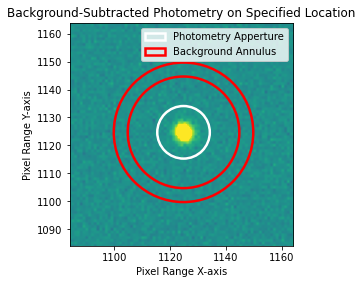

In [396]:
data = file_names[250]
img = read_file(data)
x, y, i = Centroid(data, sn_pos[0], sn_pos[1])

halfmax = i/2
clos_idx = (np.abs(img[int(y[0].round())][int(x[0].round())-20:int(x[0].round())+20] - halfmax)).argmin()+int(x[0].round()-20)
sigma = np.abs(x[0].round()-clos_idx)
fwhm = 2*np.sqrt(2*np.log(2))*sigma
app_size = 2*fwhm

AperPhot(data, app_loc=(x[0], y[0]), app_size=app_size)

print('halfmax = ', halfmax)
print('clos_idx = ', clos_idx)
print('sigma = ', sigma)
print('fwhm = ', fwhm)
print('app_size = ', app_size)
print('Photometry value = ', AperPhot(data, app_loc=(x[0], y[0]), app_size=app_size))

positions = (x[0], y[0])
aperture = CircularAperture(positions, r=app_size)
annulus_aperture = CircularAnnulus(positions, r_in=20, r_out=25)

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.imshow(img, vmin = -100, vmax = 100, origin = 'lower', cmap = 'viridis')
plt.axis([int(x[0])-40, int(x[0])+40, int(y[0])-40, int(y[0])+40])
aperture.plot(color = 'white', lw = 2.5, alpha = 1, label='Photometry Apperture')
annulus_aperture.plot(color = 'red', lw = 2.5, alpha = 1, label='Background Annulus')
plt.legend()
plt.xlabel('Pixel Range X-axis')
plt.ylabel('Pixel Range Y-axis')
plt.title('Background-Subtracted Photometry on Specified Location')
plt.savefig('Lab3_AperPhotTest' + '.png', bbox_inches='tight', dpi=400)

**Filtering Images Via The Aperture Photometry Function**

In [254]:
for i in good_files:
    data = i
    img = read_file(i)
    
    a = False
    b = False
    c = False
    
    x1, y1, intensity1 = Centroid(data, ref1_pos[0], ref1_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity1/2
    clos_idx = (np.abs(img[int(y1[0].round())][int(x1[0].round())-20:int(x1[0].round())+20] - halfmax)).argmin()+int(x1[0].round()-20)
    sigma = np.abs(x1[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    if app_size <= 0.0:
        a = True
    
    x2, y2, intensity2 = Centroid(data, ref2_pos[0], ref2_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity2/2
    clos_idx = (np.abs(img[int(y2[0].round())][int(x2[0].round())-20:int(x2[0].round())+20] - halfmax)).argmin()+int(x2[0].round()-20)
    sigma = np.abs(x2[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    if app_size <= 0.0:
        b = True
        
    x3, y3, intensity3 = Centroid(data, ref3_pos[0], ref3_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity3/2
    clos_idx = (np.abs(img[int(y3[0].round())][int(x3[0].round())-20:int(x3[0].round())+20] - halfmax)).argmin()+int(x3[0].round()-20)
    sigma = np.abs(x3[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    if app_size <= 0.0:
        c = True
    
    if a or b or c:
        good_files.remove(i)

In [256]:
for i in bad_examples:
    if i in good_files:
        good_files.remove(i)

**Applying Photometric Routine to the Entire Set of Supernova Images (n=433)**

In [258]:
print(len(good_files))
print(good_files)

406
['AST325-326-SN-20150920.9181.fits', 'AST325-326-SN-20150920.9361.fits', 'AST325-326-SN-20150920.9535.fits', 'AST325-326-SN-20150922.2569.fits', 'AST325-326-SN-20150922.2736.fits', 'AST325-326-SN-20150922.2889.fits', 'AST325-326-SN-20150922.5444.fits', 'AST325-326-SN-20150922.5604.fits', 'AST325-326-SN-20150922.5778.fits', 'AST325-326-SN-20150922.6014.fits', 'AST325-326-SN-20150922.6236.fits', 'AST325-326-SN-20150922.6410.fits', 'AST325-326-SN-20150922.6569.fits', 'AST325-326-SN-20150922.6757.fits', 'AST325-326-SN-20150922.6944.fits', 'AST325-326-SN-20150922.7722.fits', 'AST325-326-SN-20150924.5410.fits', 'AST325-326-SN-20150924.5611.fits', 'AST325-326-SN-20150924.5806.fits', 'AST325-326-SN-20150924.5986.fits', 'AST325-326-SN-20150924.8979.fits', 'AST325-326-SN-20150924.9139.fits', 'AST325-326-SN-20150924.9312.fits', 'AST325-326-SN-20150924.9486.fits', 'AST325-326-SN-20150924.9660.fits', 'AST325-326-SN-20150924.9819.fits', 'AST325-326-SN-20150924.9979.fits', 'AST325-326-SN-20150925

In [ ]:
#ref1_phot = []
#ref2_phot = []
#ref3_phot = []
#sn_phot = []
del_lst = []
ref1_phot_std = []
ref2_phot_std = []
ref3_phot_std = []
sn_phot_std = []

for i in good_files:
    data = i
    img = read_file(i)
    
    #centroiding algorithm
    x1, y1, intensity1 = Centroid(data, ref1_pos[0], ref1_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity1/2
    clos_idx = (np.abs(img[int(y1[0].round())][int(x1[0].round())-20:int(x1[0].round())+20] - halfmax)).argmin()+int(x1[0].round()-20)
    sigma = np.abs(x1[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    ref1_phot_val = AperPhot(data, app_loc=(x1[0], y1[0]), app_size=app_size)[0]
    ref1_phot_std_val = AperPhot(data, app_loc=(x1[0], y1[0]), app_size=app_size)[1]
    
    #centroiding algorithm
    x2, y2, intensity2 = Centroid(data, ref2_pos[0], ref2_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity2/2
    clos_idx = (np.abs(img[int(y2[0].round())][int(x2[0].round())-20:int(x2[0].round())+20] - halfmax)).argmin()+int(x2[0].round()-20)
    sigma = np.abs(x2[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    ref2_phot_val = AperPhot(data, app_loc=(x2[0], y2[0]), app_size=app_size)[0]
    ref2_phot_std_val = AperPhot(data, app_loc=(x2[0], y2[0]), app_size=app_size)[1]
    
    #centroiding algorithm
    x3, y3, intensity3 = Centroid(data, ref3_pos[0], ref3_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity3/2
    clos_idx = (np.abs(img[int(y3[0].round())][int(x3[0].round())-20:int(x3[0].round())+20] - halfmax)).argmin()+int(x3[0].round()-20)
    sigma = np.abs(x3[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    ref3_phot_val = AperPhot(data, app_loc=(x3[0], y3[0]), app_size=app_size)[0]
    ref3_phot_std_val = AperPhot(data, app_loc=(x3[0], y3[0]), app_size=app_size)[1]
    
    x4 = sn_pos[0]
    y4 = sn_pos[1]
    app_size = 10
    sn_phot_val = AperPhot(data, app_loc=(x4, y4), app_size=app_size)[0]
    sn_phot_std

In [14]:
#ref1_phot = []
#ref2_phot = []
#ref3_phot = []
#sn_phot = []
#del_lst = []
ref1_phot_std = []
ref2_phot_std = []
ref3_phot_std = []
sn_phot_std = []

for i in good_files:
    data = i
    img = read_file(i)
    
    #centroiding algorithm
    x1, y1, intensity1 = Centroid(data, ref1_pos[0], ref1_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity1/2
    clos_idx = (np.abs(img[int(y1[0].round())][int(x1[0].round())-20:int(x1[0].round())+20] - halfmax)).argmin()+int(x1[0].round()-20)
    sigma = np.abs(x1[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    ref1_phot_val = AperPhot(data, app_loc=(x1[0], y1[0]), app_size=app_size)[0]
    ref1_phot_std_val = AperPhot(data, app_loc=(x1[0], y1[0]), app_size=app_size)[1]
    
    #centroiding algorithm
    x2, y2, intensity2 = Centroid(data, ref2_pos[0], ref2_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity2/2
    clos_idx = (np.abs(img[int(y2[0].round())][int(x2[0].round())-20:int(x2[0].round())+20] - halfmax)).argmin()+int(x2[0].round()-20)
    sigma = np.abs(x2[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    ref2_phot_val = AperPhot(data, app_loc=(x2[0], y2[0]), app_size=app_size)[0]
    ref2_phot_std_val = AperPhot(data, app_loc=(x2[0], y2[0]), app_size=app_size)[1]
    
    #centroiding algorithm
    x3, y3, intensity3 = Centroid(data, ref3_pos[0], ref3_pos[1])
    #apperture radius size calcualtion method
    halfmax = intensity3/2
    clos_idx = (np.abs(img[int(y3[0].round())][int(x3[0].round())-20:int(x3[0].round())+20] - halfmax)).argmin()+int(x3[0].round()-20)
    sigma = np.abs(x3[0].round()-clos_idx)
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    app_size = 2*fwhm
    ref3_phot_val = AperPhot(data, app_loc=(x3[0], y3[0]), app_size=app_size)[0]
    ref3_phot_std_val = AperPhot(data, app_loc=(x3[0], y3[0]), app_size=app_size)[1]
    
    x4 = sn_pos[0]
    y4 = sn_pos[1]
    app_size = 10
    sn_phot_val = AperPhot(data, app_loc=(x4, y4), app_size=app_size)[0]
    sn_phot_std_val = AperPhot(data, app_loc=(x4, y4), app_size=app_size)[1]

    if sn_phot_val>=0 and ref1_phot_val>=0 and ref2_phot_val>=0 and ref3_phot_val >= 70000:
        ref1_phot_std.append(ref1_phot_std_val)
        ref2_phot_std.append(ref2_phot_std_val)
        ref3_phot_std.append(ref3_phot_std_val)
        sn_phot_std.append(sn_phot_std_val)
        
    

In [16]:
print(len(ref1_phot_std),len(ref2_phot_std), len(ref3_phot_std), len(sn_phot_std))

357 357 357 357


In [534]:
print('Length of good_files: ', len(good_files))
print('Length of del_lst: ', len(del_lst))
print(len(ref1_phot), len(ref2_phot), len(ref3_phot), len(sn_phot))
#print('Length of good_files1: ', len(good_files1))
#print(good_files)
#good_files1 = ['AST325-326-SN-20150920.9181.fits', 'AST325-326-SN-20150922.2736.fits', 'AST325-326-SN-20150922.2889.fits', 'AST325-326-SN-20150922.5444.fits', 'AST325-326-SN-20150922.5778.fits', 'AST325-326-SN-20150922.6236.fits', 'AST325-326-SN-20150922.6410.fits', 'AST325-326-SN-20150922.6944.fits', 'AST325-326-SN-20150922.7722.fits', 'AST325-326-SN-20150924.5611.fits', 'AST325-326-SN-20150924.5806.fits', 'AST325-326-SN-20150924.5986.fits', 'AST325-326-SN-20150924.8979.fits', 'AST325-326-SN-20150924.9139.fits', 'AST325-326-SN-20150924.9312.fits', 'AST325-326-SN-20150924.9486.fits', 'AST325-326-SN-20150924.9660.fits', 'AST325-326-SN-20150924.9819.fits', 'AST325-326-SN-20150924.9979.fits', 'AST325-326-SN-20150925.0139.fits', 'AST325-326-SN-20150925.0472.fits', 'AST325-326-SN-20150925.0653.fits', 'AST325-326-SN-20150925.0819.fits', 'AST325-326-SN-20150925.0972.fits', 'AST325-326-SN-20150925.1118.fits', 'AST325-326-SN-20150925.1264.fits', 'AST325-326-SN-20150926.5361.fits', 'AST325-326-SN-20150926.5535.fits', 'AST325-326-SN-20150926.5701.fits', 'AST325-326-SN-20150926.5944.fits', 'AST325-326-SN-20150926.6125.fits', 'AST325-326-SN-20150926.6299.fits', 'AST325-326-SN-20150926.6472.fits', 'AST325-326-SN-20150926.6486.fits', 'AST325-326-SN-20150926.6715.fits', 'AST325-326-SN-20150926.6875.fits', 'AST325-326-SN-20150926.7090.fits', 'AST325-326-SN-20150926.7368.fits', 'AST325-326-SN-20150926.7563.fits', 'AST325-326-SN-20150928.1271.fits', 'AST325-326-SN-20150928.1417.fits', 'AST325-326-SN-20150928.1569.fits', 'AST325-326-SN-20150928.1715.fits', 'AST325-326-SN-20150928.1861.fits', 'AST325-326-SN-20150928.2014.fits', 'AST325-326-SN-20150928.2215.fits', 'AST325-326-SN-20150928.2389.fits', 'AST325-326-SN-20150928.2542.fits', 'AST325-326-SN-20150928.2694.fits', 'AST325-326-SN-20150928.2847.fits', 'AST325-326-SN-20150928.3014.fits', 'AST325-326-SN-20150928.3160.fits', 'AST325-326-SN-20150928.3333.fits', 'AST325-326-SN-20150928.3493.fits', 'AST325-326-SN-20150928.3632.fits', 'AST325-326-SN-20150928.3826.fits', 'AST325-326-SN-20150928.5333.fits', 'AST325-326-SN-20150928.5535.fits', 'AST325-326-SN-20150928.5708.fits', 'AST325-326-SN-20150928.5903.fits', 'AST325-326-SN-20150928.6118.fits', 'AST325-326-SN-20150928.6313.fits', 'AST325-326-SN-20150928.6514.fits', 'AST325-326-SN-20150928.6715.fits', 'AST325-326-SN-20150928.6903.fits', 'AST325-326-SN-20150928.7062.fits', 'AST325-326-SN-20150928.7271.fits', 'AST325-326-SN-20150928.7458.fits', 'AST325-326-SN-20150930.3333.fits', 'AST325-326-SN-20150930.3486.fits', 'AST325-326-SN-20150930.3639.fits', 'AST325-326-SN-20150930.3778.fits', 'AST325-326-SN-20150930.5528.fits', 'AST325-326-SN-20150930.6514.fits', 'AST325-326-SN-20150930.6875.fits', 'AST325-326-SN-20150930.7035.fits', 'AST325-326-SN-20150930.7229.fits', 'AST325-326-SN-20150930.7410.fits', 'AST325-326-SN-20150930.7604.fits', 'AST325-326-SN-20151002.1243.fits', 'AST325-326-SN-20151002.1410.fits', 'AST325-326-SN-20151002.1556.fits', 'AST325-326-SN-20151002.1736.fits', 'AST325-326-SN-20151002.1903.fits', 'AST325-326-SN-20151002.2083.fits', 'AST325-326-SN-20151002.2306.fits', 'AST325-326-SN-20151002.2451.fits', 'AST325-326-SN-20151002.2597.fits', 'AST325-326-SN-20151002.2743.fits', 'AST325-326-SN-20151002.2896.fits', 'AST325-326-SN-20151002.3035.fits', 'AST325-326-SN-20151002.3194.fits', 'AST325-326-SN-20151002.3347.fits', 'AST325-326-SN-20151002.3479.fits', 'AST325-326-SN-20151002.3632.fits', 'AST325-326-SN-20151002.3750.fits', 'AST325-326-SN-20151002.5125.fits', 'AST325-326-SN-20151002.5292.fits', 'AST325-326-SN-20151002.5451.fits', 'AST325-326-SN-20151002.5646.fits', 'AST325-326-SN-20151002.5868.fits', 'AST325-326-SN-20151002.6049.fits', 'AST325-326-SN-20151002.6236.fits', 'AST325-326-SN-20151002.6437.fits', 'AST325-326-SN-20151002.6674.fits', 'AST325-326-SN-20151002.6861.fits', 'AST325-326-SN-20151002.7014.fits', 'AST325-326-SN-20151002.7382.fits', 'AST325-326-SN-20151002.7507.fits', 'AST325-326-SN-20151004.1083.fits', 'AST325-326-SN-20151004.1236.fits', 'AST325-326-SN-20151004.1389.fits', 'AST325-326-SN-20151004.1549.fits', 'AST325-326-SN-20151004.1708.fits', 'AST325-326-SN-20151004.1875.fits', 'AST325-326-SN-20151004.2069.fits', 'AST325-326-SN-20151004.2236.fits', 'AST325-326-SN-20151004.2375.fits', 'AST325-326-SN-20151004.2514.fits', 'AST325-326-SN-20151004.2660.fits', 'AST325-326-SN-20151004.2806.fits', 'AST325-326-SN-20151004.2944.fits', 'AST325-326-SN-20151004.3083.fits', 'AST325-326-SN-20151004.3243.fits', 'AST325-326-SN-20151004.3396.fits', 'AST325-326-SN-20151004.3535.fits', 'AST325-326-SN-20151004.3687.fits', 'AST325-326-SN-20151004.3792.fits', 'AST325-326-SN-20151004.5104.fits', 'AST325-326-SN-20151004.5257.fits', 'AST325-326-SN-20151004.5438.fits', 'AST325-326-SN-20151004.5840.fits', 'AST325-326-SN-20151004.6014.fits', 'AST325-326-SN-20151004.6528.fits', 'AST325-326-SN-20151004.6757.fits', 'AST325-326-SN-20151004.6924.fits', 'AST325-326-SN-20151004.7097.fits', 'AST325-326-SN-20151004.7278.fits', 'AST325-326-SN-20151004.7403.fits', 'AST325-326-SN-20151004.7528.fits', 'AST325-326-SN-20151004.9014.fits', 'AST325-326-SN-20151004.9208.fits', 'AST325-326-SN-20151004.9410.fits', 'AST325-326-SN-20151004.9576.fits', 'AST325-326-SN-20151004.9757.fits', 'AST325-326-SN-20151004.9910.fits', 'AST325-326-SN-20151005.0056.fits', 'AST325-326-SN-20151005.0222.fits', 'AST325-326-SN-20151005.0361.fits', 'AST325-326-SN-20151005.0514.fits', 'AST325-326-SN-20151005.0653.fits', 'AST325-326-SN-20151005.0806.fits', 'AST325-326-SN-20151005.0951.fits', 'AST325-326-SN-20151005.1104.fits', 'AST325-326-SN-20151006.1042.fits', 'AST325-326-SN-20151006.1201.fits', 'AST325-326-SN-20151006.1340.fits', 'AST325-326-SN-20151006.1493.fits', 'AST325-326-SN-20151006.1694.fits', 'AST325-326-SN-20151006.1861.fits', 'AST325-326-SN-20151006.2292.fits', 'AST325-326-SN-20151006.2451.fits', 'AST325-326-SN-20151006.2604.fits', 'AST325-326-SN-20151006.2743.fits', 'AST325-326-SN-20151006.2882.fits', 'AST325-326-SN-20151006.3014.fits', 'AST325-326-SN-20151006.3153.fits', 'AST325-326-SN-20151006.8722.fits', 'AST325-326-SN-20151006.8910.fits', 'AST325-326-SN-20151006.9361.fits', 'AST325-326-SN-20151006.9528.fits', 'AST325-326-SN-20151006.9889.fits', 'AST325-326-SN-20151007.0049.fits', 'AST325-326-SN-20151007.0271.fits', 'AST325-326-SN-20151007.0451.fits', 'AST325-326-SN-20151007.0604.fits', 'AST325-326-SN-20151007.0785.fits', 'AST325-326-SN-20151007.0924.fits', 'AST325-326-SN-20151008.1021.fits', 'AST325-326-SN-20151008.1201.fits', 'AST325-326-SN-20151008.1354.fits', 'AST325-326-SN-20151008.1528.fits', 'AST325-326-SN-20151008.1701.fits', 'AST325-326-SN-20151008.1903.fits', 'AST325-326-SN-20151008.2090.fits', 'AST325-326-SN-20151008.2271.fits', 'AST325-326-SN-20151008.2437.fits', 'AST325-326-SN-20151008.2597.fits', 'AST325-326-SN-20151008.2785.fits', 'AST325-326-SN-20151008.2951.fits', 'AST325-326-SN-20151008.3118.fits', 'AST325-326-SN-20151008.3264.fits', 'AST325-326-SN-20151008.3389.fits', 'AST325-326-SN-20151008.3514.fits', 'AST325-326-SN-20151008.3632.fits', 'AST325-326-SN-20151008.3687.fits', 'AST325-326-SN-20151008.3743.fits', 'AST325-326-SN-20151008.4937.fits', 'AST325-326-SN-20151008.5090.fits', 'AST325-326-SN-20151008.5250.fits', 'AST325-326-SN-20151008.5403.fits', 'AST325-326-SN-20151008.5583.fits', 'AST325-326-SN-20151008.5757.fits', 'AST325-326-SN-20151008.5931.fits', 'AST325-326-SN-20151008.6111.fits', 'AST325-326-SN-20151008.6271.fits', 'AST325-326-SN-20151008.6424.fits', 'AST325-326-SN-20151008.6590.fits', 'AST325-326-SN-20151008.6743.fits', 'AST325-326-SN-20151008.6944.fits', 'AST325-326-SN-20151008.7097.fits', 'AST325-326-SN-20151008.7181.fits', 'AST325-326-SN-20151008.7292.fits', 'AST325-326-SN-20151008.7389.fits', 'AST325-326-SN-20151008.7451.fits', 'AST325-326-SN-20151008.7549.fits', 'AST325-326-SN-20151008.7597.fits', 'AST325-326-SN-20151008.8847.fits', 'AST325-326-SN-20151008.9028.fits', 'AST325-326-SN-20151008.9229.fits', 'AST325-326-SN-20151008.9424.fits', 'AST325-326-SN-20151008.9958.fits', 'AST325-326-SN-20151009.0104.fits', 'AST325-326-SN-20151009.0264.fits', 'AST325-326-SN-20151009.0410.fits', 'AST325-326-SN-20151009.0576.fits', 'AST325-326-SN-20151009.0722.fits', 'AST325-326-SN-20151009.0868.fits', 'AST325-326-SN-20151010.1007.fits', 'AST325-326-SN-20151010.4972.fits', 'AST325-326-SN-20151010.5125.fits', 'AST325-326-SN-20151010.5285.fits', 'AST325-326-SN-20151010.5458.fits', 'AST325-326-SN-20151010.5639.fits', 'AST325-326-SN-20151010.5903.fits', 'AST325-326-SN-20151010.6063.fits', 'AST325-326-SN-20151010.6222.fits', 'AST325-326-SN-20151010.6389.fits', 'AST325-326-SN-20151010.6535.fits', 'AST325-326-SN-20151010.6694.fits', 'AST325-326-SN-20151010.6854.fits', 'AST325-326-SN-20151010.8576.fits', 'AST325-326-SN-20151010.8993.fits', 'AST325-326-SN-20151010.9215.fits', 'AST325-326-SN-20151010.9410.fits', 'AST325-326-SN-20151010.9715.fits', 'AST325-326-SN-20151010.9861.fits', 'AST325-326-SN-20151011.0007.fits', 'AST325-326-SN-20151011.0319.fits', 'AST325-326-SN-20151011.0632.fits', 'AST325-326-SN-20151011.0785.fits', 'AST325-326-SN-20151011.0931.fits', 'AST325-326-SN-20151012.0868.fits', 'AST325-326-SN-20151012.1021.fits', 'AST325-326-SN-20151012.1208.fits', 'AST325-326-SN-20151012.1375.fits', 'AST325-326-SN-20151012.1576.fits', 'AST325-326-SN-20151012.1750.fits', 'AST325-326-SN-20151012.1917.fits', 'AST325-326-SN-20151012.2069.fits', 'AST325-326-SN-20151012.2118.fits', 'AST325-326-SN-20151012.2243.fits', 'AST325-326-SN-20151012.8632.fits', 'AST325-326-SN-20151012.8847.fits', 'AST325-326-SN-20151012.9111.fits', 'AST325-326-SN-20151012.9340.fits', 'AST325-326-SN-20151012.9500.fits', 'AST325-326-SN-20151012.9646.fits', 'AST325-326-SN-20151012.9799.fits', 'AST325-326-SN-20151012.9944.fits', 'AST325-326-SN-20151013.0083.fits', 'AST325-326-SN-20151013.0229.fits', 'AST325-326-SN-20151013.0382.fits', 'AST325-326-SN-20151013.0583.fits', 'AST325-326-SN-20151013.0750.fits', 'AST325-326-SN-20151014.4847.fits', 'AST325-326-SN-20151014.5007.fits', 'AST325-326-SN-20151014.5167.fits', 'AST325-326-SN-20151014.5319.fits', 'AST325-326-SN-20151014.5500.fits', 'AST325-326-SN-20151014.5674.fits', 'AST325-326-SN-20151014.5833.fits', 'AST325-326-SN-20151014.6000.fits', 'AST325-326-SN-20151014.6146.fits', 'AST325-326-SN-20151014.6299.fits', 'AST325-326-SN-20151014.6444.fits', 'AST325-326-SN-20151014.6590.fits', 'AST325-326-SN-20151014.6743.fits', 'AST325-326-SN-20151014.6896.fits', 'AST325-326-SN-20151014.6993.fits', 'AST325-326-SN-20151014.7090.fits', 'AST325-326-SN-20151014.7188.fits', 'AST325-326-SN-20151014.7236.fits', 'AST325-326-SN-20151014.7285.fits', 'AST325-326-SN-20151014.7326.fits', 'AST325-326-SN-20151014.7375.fits', 'AST325-326-SN-20151014.7431.fits', 'AST325-326-SN-20151016.4764.fits', 'AST325-326-SN-20151016.4917.fits', 'AST325-326-SN-20151016.5069.fits', 'AST325-326-SN-20151016.5229.fits', 'AST325-326-SN-20151017.4708.fits', 'AST325-326-SN-20151017.5014.fits', 'AST325-326-SN-20151017.5167.fits', 'AST325-326-SN-20151019.4715.fits', 'AST325-326-SN-20151019.4889.fits', 'AST325-326-SN-20151019.5056.fits', 'AST325-326-SN-20151019.5215.fits', 'AST325-326-SN-20151019.5396.fits', 'AST325-326-SN-20151020.4653.fits', 'AST325-326-SN-20151020.4813.fits', 'AST325-326-SN-20151020.4979.fits', 'AST325-326-SN-20151020.5174.fits', 'AST325-326-SN-20151021.0063.fits', 'AST325-326-SN-20151021.0208.fits', 'AST325-326-SN-20151021.0340.fits', 'AST325-326-SN-20151021.0493.fits', 'AST325-326-SN-20151021.0646.fits', 'AST325-326-SN-20151022.0132.fits', 'AST325-326-SN-20151022.0278.fits', 'AST325-326-SN-20151022.0431.fits', 'AST325-326-SN-20151022.0569.fits', 'AST325-326-SN-20151022.0708.fits', 'AST325-326-SN-20151023.4188.fits', 'AST325-326-SN-20151023.4333.fits', 'AST325-326-SN-20151023.4514.fits', 'AST325-326-SN-20151024.0069.fits', 'AST325-326-SN-20151024.0222.fits', 'AST325-326-SN-20151024.0361.fits', 'AST325-326-SN-20151024.0514.fits', 'AST325-326-SN-20151024.0667.fits', 'AST325-326-SN-20151024.4125.fits', 'AST325-326-SN-20151024.4271.fits', 'AST325-326-SN-20151024.4417.fits', 'AST325-326-SN-20151024.4562.fits', 'AST325-326-SN-20151025.4424.fits', 'AST325-326-SN-20151026.0125.fits', 'AST325-326-SN-20151026.0264.fits', 'AST325-326-SN-20151026.0694.fits', 'AST325-326-SN-20151027.0153.fits', 'AST325-326-SN-20151027.0299.fits', 'AST325-326-SN-20151027.0438.fits', 'AST325-326-SN-20151027.0590.fits', 'AST325-326-SN-20151027.0736.fits', 'AST325-326-SN-20151027.0896.fits', 'AST325-326-SN-20151027.1056.fits', 'AST325-326-SN-20151027.1208.fits', 'AST325-326-SN-20151027.1375.fits', 'AST325-326-SN-20151027.1549.fits', 'AST325-326-SN-20151027.1743.fits', 'AST325-326-SN-20151027.1882.fits', 'AST325-326-SN-20151027.2326.fits', 'AST325-326-SN-20151027.2479.fits', 'AST325-326-SN-20151027.2660.fits', 'AST325-326-SN-20151027.2951.fits', 'AST325-326-SN-20151027.3049.fits', 'AST325-326-SN-20151027.3174.fits', 'AST325-326-SN-20151028.4257.fits', 'AST325-326-SN-20151028.4417.fits', 'AST325-326-SN-20151028.4569.fits', 'AST325-326-SN-20151029.0146.fits', 'AST325-326-SN-20151029.0299.fits', 'AST325-326-SN-20151029.0458.fits', 'AST325-326-SN-20151029.0743.fits', 'AST325-326-SN-20151029.0917.fits', 'AST325-326-SN-20151029.1090.fits', 'AST325-326-SN-20151029.1257.fits', 'AST325-326-SN-20151029.1431.fits', 'AST325-326-SN-20151029.1778.fits', 'AST325-326-SN-20151029.1826.fits', 'AST325-326-SN-20151029.1847.fits', 'AST325-326-SN-20151029.1965.fits', 'AST325-326-SN-20151029.2264.fits', 'AST325-326-SN-20151029.2444.fits', 'AST325-326-SN-20151029.2604.fits', 'AST325-326-SN-20151029.2764.fits', 'AST325-326-SN-20151029.2917.fits', 'AST325-326-SN-20151029.3014.fits', 'AST325-326-SN-20151029.3111.fits', 'AST325-326-SN-20151029.4312.fits', 'AST325-326-SN-20151029.4500.fits', 'AST325-326-SN-20151030.0139.fits', 'AST325-326-SN-20151030.0306.fits', 'AST325-326-SN-20151030.0479.fits', 'AST325-326-SN-20151030.0653.fits', 'AST325-326-SN-20151030.0806.fits']
#print('Equality test: ', good_files == good_files1)

for i in del_lst:
    if i in good_files:
        good_files.remove(i)

print('Length of good_files: ', len(good_files))
print('Length of del_lst: ', len(del_lst))
print(len(ref1_phot), len(ref2_phot), len(ref3_phot), len(sn_phot))

%store ref1_phot
%store ref2_phot
%store ref3_phot
%store sn_phot
%store good_files

Length of good_files:  357
Length of del_lst:  49
357 357 357 357
Length of good_files:  357
Length of del_lst:  49
357 357 357 357
Stored 'ref1_phot' (list)
Stored 'ref2_phot' (list)
Stored 'ref3_phot' (list)
Stored 'sn_phot' (list)
Stored 'good_files' (ndarray)


In [17]:
%store ref1_phot_std
%store ref2_phot_std
%store ref3_phot_std
%store sn_phot_std

Stored 'ref1_phot_std' (list)
Stored 'ref2_phot_std' (list)
Stored 'ref3_phot_std' (list)
Stored 'sn_phot_std' (list)


In [9]:
%store -r

In [10]:
good_file_times = []
for f in good_files:
    header = fits.open(img_folder / f)[0].header
    dt = datetime.fromisoformat(header["DATE-OBS"])
    good_file_times.append(dt)
#sort files by the same way
good_file_times, good_files = zip(*sorted(zip(good_file_times, good_files)))
good_files = np.array(good_files)
good_file_times = np.array(good_file_times)

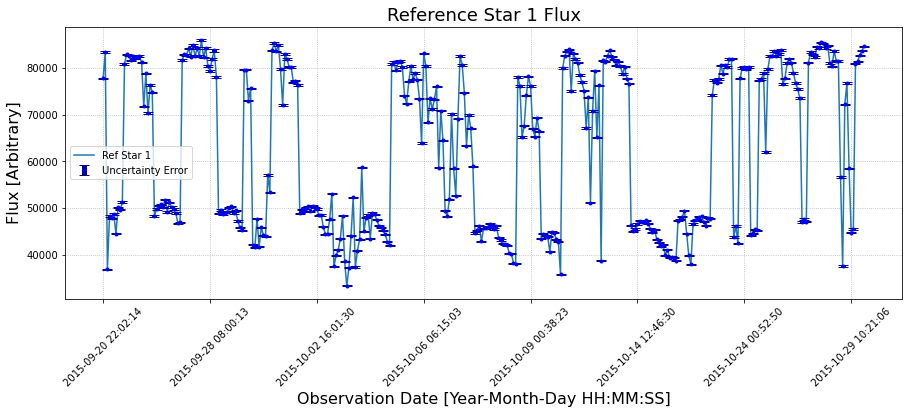

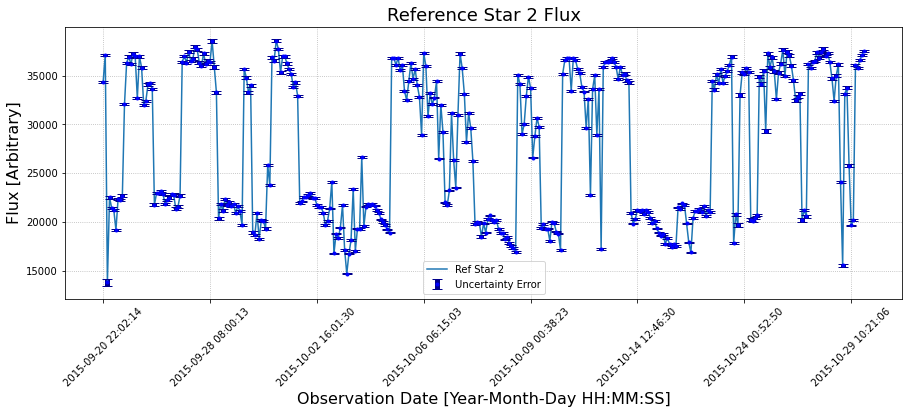

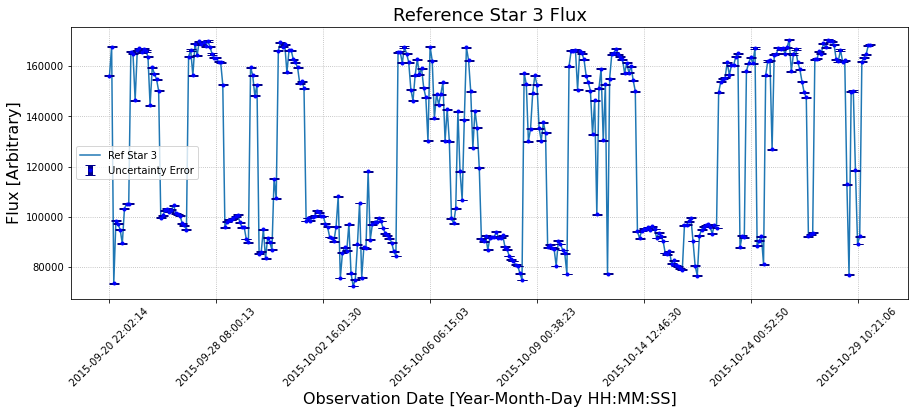

In [11]:
plt.figure(figsize = (15, 5))
plt.plot(ref1_phot ,label='Ref Star 1')
plt.errorbar(np.arange(0, len(ref1_phot)), ref1_phot, yerr = ref1_phot_std, fmt='.', color='blue', ecolor='darkblue', elinewidth=5, capsize=5, label='Uncertainty Error')
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(ref1_phot)+1, 50))
#plt.axhline(y=70000, xmin=0, xmax=3, c="black", linewidth=3, zorder=0)
#plt.yscale('log')
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Flux [Arbitrary]", size = 16)
plt.title("Reference Star 1 Flux", size = 18)
plt.legend()
plt.savefig('Lab3_RefStar1Flux' + '.png', bbox_inches='tight', dpi=400)
plt.show()

plt.figure(figsize = (15, 5))
plt.plot(ref2_phot ,label='Ref Star 2')
plt.errorbar(np.arange(0, len(ref2_phot)), ref2_phot, yerr = ref2_phot_std, fmt='.', color='blue', ecolor='darkblue', elinewidth=5, capsize=5, label='Uncertainty Error')
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(ref2_phot)+1, 50))
#plt.axhline(y=70000, xmin=0, xmax=3, c="black", linewidth=3, zorder=0)
#plt.yscale('log')
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Flux [Arbitrary]", size = 16)
plt.title("Reference Star 2 Flux", size = 18)
plt.legend()
plt.savefig('Lab3_RefStar2Flux' + '.png', bbox_inches='tight', dpi=400)
plt.show()

plt.figure(figsize = (15, 5))
plt.plot(ref3_phot ,label='Ref Star 3')
plt.errorbar(np.arange(0, len(ref3_phot)), ref3_phot, yerr = ref3_phot_std, fmt='.', color='blue', ecolor='darkblue', elinewidth=5, capsize=5, label='Uncertainty Error')
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(ref3_phot)+1, 50))
#plt.axhline(y=70000, xmin=0, xmax=3, c="black", linewidth=3, zorder=0)
#plt.yscale('log')
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Flux [Arbitrary]", size = 16)
plt.title("Reference Star 3 Flux", size = 18)
plt.legend()
plt.savefig('Lab3_RefStar3Flux' + '.png', bbox_inches='tight', dpi=400)
plt.show()

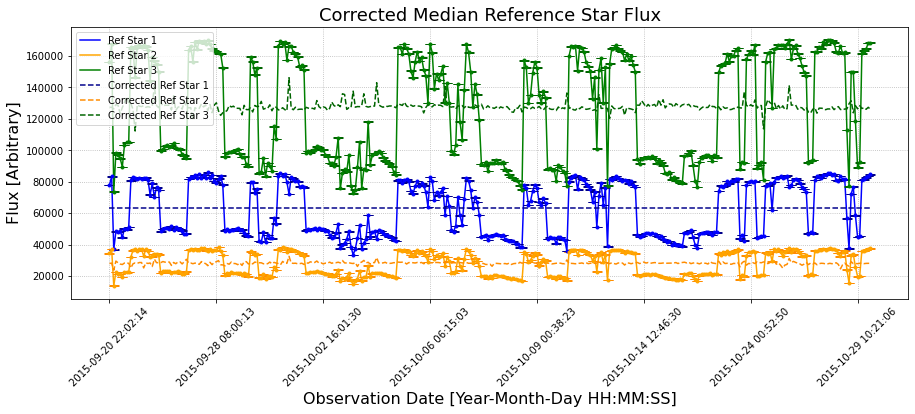

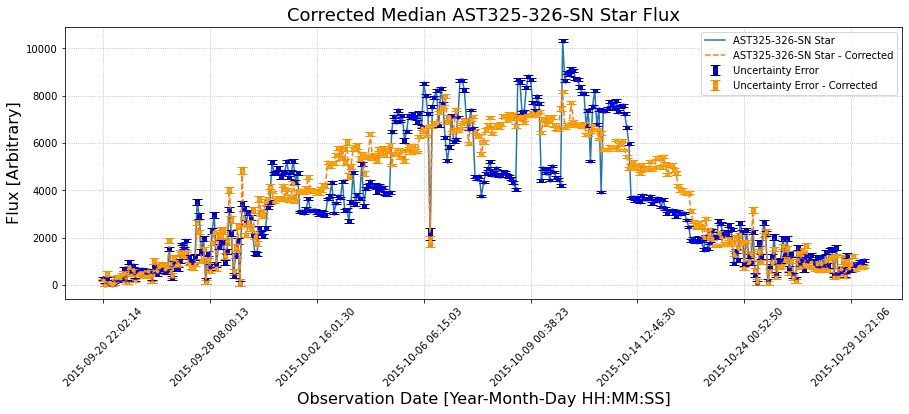

In [12]:
ref1_phot_a = np.array(ref1_phot)
ref2_phot_a = np.array(ref2_phot)
ref3_phot_a = np.array(ref3_phot)
sn_phot_a = np.array(sn_phot)
ref1_phot_std_a = np.array(ref1_phot_std)
ref2_phot_std_a = np.array(ref2_phot_std)
ref3_phot_std_a = np.array(ref3_phot_std)
sn_phot_std_a = np.array(sn_phot_std)

median_curve = np.median([ref1_phot_a, ref2_phot_a, ref3_phot_a], axis=0)
norm_med = median_curve / np.linalg.norm(median_curve)
mults = norm_med / np.median(norm_med)

#then you divide the flux arrays by mults
ref1_phot_fixed = ref1_phot_a/mults
ref2_phot_fixed = ref2_phot_a/mults
ref3_phot_fixed = ref3_phot_a/mults
sn_phot_fixed = sn_phot_a/mults
ref1_phot_std_fixed = ref1_phot_std_a/mults
ref2_phot_std_fixed = ref2_phot_std_a/mults
ref3_phot_std_fixed = ref3_phot_std_a/mults
sn_phot_std_fixed = sn_phot_std_a/mults

plt.figure(figsize = (15, 5))
plt.plot(ref1_phot, color='blue', label='Ref Star 1')
plt.errorbar(np.arange(0, len(ref1_phot)), ref1_phot, yerr = ref1_phot_std, fmt='.', color='blue', ecolor='darkblue', elinewidth=5, capsize=5)
plt.plot(ref2_phot, color='orange', label='Ref Star 2')
plt.errorbar(np.arange(0, len(ref2_phot)), ref2_phot, yerr = ref2_phot_std, fmt='.', color='orange', ecolor='darkorange', elinewidth=5, capsize=5)
plt.plot(ref3_phot, color='green', label='Ref Star 3')
plt.errorbar(np.arange(0, len(ref3_phot)), ref3_phot, yerr = ref3_phot_std, fmt='.', color='green', ecolor='darkgreen', elinewidth=5, capsize=5)
plt.plot(ref1_phot_fixed, color='darkblue', linestyle='dashed', label='Corrected Ref Star 1')
#plt.errorbar(np.arange(0, len(ref1_phot_fixed)), ref1_phot_fixed, yerr = ref1_phot_std_fixed, fmt='.', color='blue', ecolor='darkblue', elinewidth=5, capsize=5)
plt.plot(ref2_phot_fixed, color='darkorange', linestyle='dashed', label='Corrected Ref Star 2')
#plt.errorbar(np.arange(0, len(ref2_phot_fixed)), ref2_phot_fixed, yerr = ref2_phot_std_fixed, fmt='.', color='orange', ecolor='darkorange', elinewidth=5, capsize=5)
plt.plot(ref3_phot_fixed, color='darkgreen', linestyle='dashed', label='Corrected Ref Star 3')
#plt.errorbar(np.arange(0, len(ref3_phot_fixed)), ref3_phot_fixed, yerr = ref3_phot_std_fixed, fmt='.', color='green', ecolor='darkgreen', elinewidth=5, capsize=5)
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(ref1_phot)+1, 50))
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Flux [Arbitrary]", size = 16)
plt.title("Corrected Median Reference Star Flux", size = 18)
plt.legend()
plt.savefig('Lab3_RefStarsFlux' + '.png', bbox_inches='tight', dpi=400)
plt.show()

plt.figure(figsize = (15, 5))
plt.plot(sn_phot, label='AST325-326-SN Star')
plt.errorbar(np.arange(0, len(sn_phot)), sn_phot, yerr = sn_phot_std, fmt='.', color='blue', ecolor='darkblue', elinewidth=5, capsize=5, label='Uncertainty Error')
plt.plot(sn_phot_fixed, linestyle='dashed', label='AST325-326-SN Star - Corrected')
plt.errorbar(np.arange(0, len(sn_phot_fixed)), sn_phot_fixed, yerr = sn_phot_std_fixed, fmt='.', color='orange', ecolor='darkorange', elinewidth=5, capsize=5, label='Uncertainty Error - Corrected')
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(sn_phot)+1, 50))
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Flux [Arbitrary]", size = 16)
plt.title("Corrected Median AST325-326-SN Star Flux", size = 18)
plt.legend()
plt.savefig('Lab3_SNStarFlux' + '.png', bbox_inches='tight', dpi=400)
plt.show()

**Create the Light Curve of the Supernova**

In [13]:
ref1_mag = 16.32 #+- 0.07
ref2_mag = 17.16 #+- 0.08
ref3_mag = 15.61 #+- 0.02
sn_mag1 = 2.512*np.log(ref1_phot_fixed/sn_phot_fixed)+ref1_mag
sn_mag2 = 2.512*np.log(ref2_phot_fixed/sn_phot_fixed)+ref2_mag
sn_mag3 = 2.512*np.log(ref3_phot_fixed/sn_phot_fixed)+ref3_mag
#Magnitude Uncertainty Formula: np.sqrt((((2.512/b)/((np.log(10)*a)/b))*δa)**2+(-(((b**(-1))/(np.log(10)*a))*2.512*a)*δb)**2+(1*δc)**2)
sn_mag1_std = np.sqrt((((2.512/sn_phot_fixed)/((np.log(10)*ref1_phot_fixed)/sn_phot_fixed))*ref1_phot_std_fixed)**2+(-(((sn_phot_fixed**(-1))/(np.log(10)*ref1_phot_fixed))*2.512*ref1_phot_fixed)*sn_phot_std_fixed)**2+(1*0.07)**2)
sn_mag2_std = np.sqrt((((2.512/sn_phot_fixed)/((np.log(10)*ref2_phot_fixed)/sn_phot_fixed))*ref2_phot_std_fixed)**2+(-(((sn_phot_fixed**(-1))/(np.log(10)*ref2_phot_fixed))*2.512*ref2_phot_fixed)*sn_phot_std_fixed)**2+(1*0.08)**2)
sn_mag3_std = np.sqrt((((2.512/sn_phot_fixed)/((np.log(10)*ref3_phot_fixed)/sn_phot_fixed))*ref3_phot_std_fixed)**2+(-(((sn_phot_fixed**(-1))/(np.log(10)*ref3_phot_fixed))*2.512*ref3_phot_fixed)*sn_phot_std_fixed)**2+(1*0.02)**2)

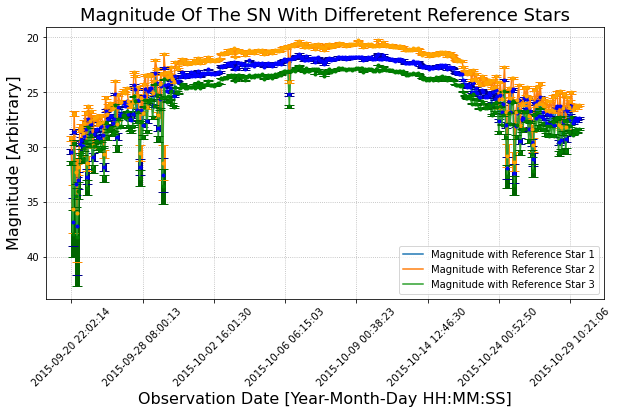

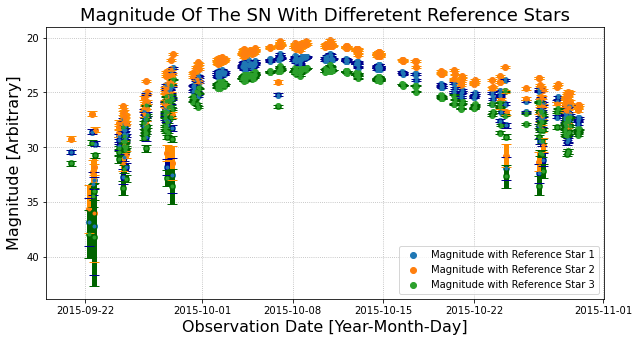

In [14]:
plt.figure(figsize = (10, 5))
plt.plot(sn_mag1, label='Magnitude with Reference Star 1')
plt.errorbar(np.arange(0, len(sn_mag1)), sn_mag1, yerr = sn_mag1_std, fmt='.', color='blue', ecolor='darkblue', elinewidth=5, capsize=5)
plt.plot(sn_mag2, label='Magnitude with Reference Star 2')
plt.errorbar(np.arange(0, len(sn_mag2)), sn_mag2, yerr = sn_mag2_std, fmt='.', color='orange', ecolor='darkorange', elinewidth=5, capsize=5)
plt.plot(sn_mag3, label='Magnitude with Reference Star 3')
plt.errorbar(np.arange(0, len(sn_mag3)), sn_mag3, yerr = sn_mag3_std, fmt='.', color='green', ecolor='darkgreen', elinewidth=5, capsize=5)
plt.gca().invert_yaxis()
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(sn_mag1)+1, 50))
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Magnitude [Arbitrary]", size = 16)
plt.title("Magnitude Of The SN With Differetent Reference Stars", size = 18)
plt.legend()
plt.savefig('Lab3_SNMag_line' + '.png', bbox_inches='tight', dpi=400)
plt.show()

plt.figure(figsize = (10, 5))
plt.scatter(good_file_times, sn_mag1, label='Magnitude with Reference Star 1')
plt.errorbar(good_file_times, sn_mag1, yerr = sn_mag1_std, fmt='.', ecolor='darkblue', elinewidth=5, capsize=5)
plt.scatter(good_file_times, sn_mag2, label='Magnitude with Reference Star 2')
plt.errorbar(good_file_times, sn_mag2, yerr = sn_mag2_std, fmt='.', ecolor='darkorange', elinewidth=5, capsize=5)
plt.scatter(good_file_times, sn_mag3, label='Magnitude with Reference Star 3')
plt.errorbar(good_file_times, sn_mag3, yerr = sn_mag3_std, fmt='.', ecolor='darkgreen', elinewidth=5, capsize=5)
plt.gca().invert_yaxis()
#plt.xticks(rotation = 45)
#plt.xticks(good_file_times[::40], rotation=45)
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day]', size = 16)
plt.ylabel("Magnitude [Arbitrary]", size = 16)
plt.title("Magnitude Of The SN With Differetent Reference Stars", size = 18)
plt.legend()
plt.savefig('Lab3_SNMag_Scatter' + '.png', bbox_inches='tight', dpi=400)
plt.show()

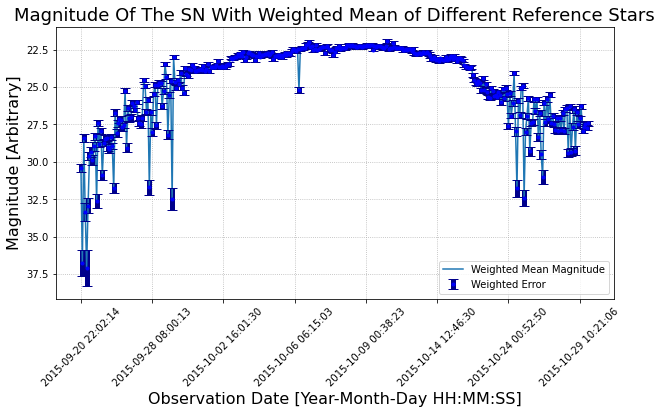

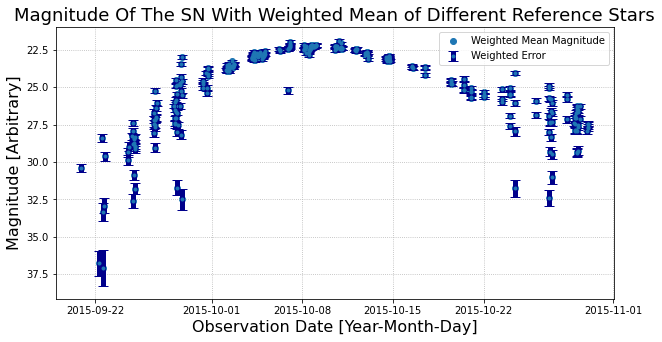

In [15]:
#Taking weighted mean and weighted error
sn_mag1_weight = 1/sn_mag1_std
sn_mag2_weight = 1/sn_mag2_std
sn_mag3_weight = 1/sn_mag3_std
sn_mag_wmean = (sn_mag1*sn_mag1_weight+sn_mag2*sn_mag2_weight+sn_mag3*sn_mag3_weight)/(sn_mag1_weight+sn_mag2_weight+sn_mag3_weight)
sn_mag_wmean_std = 1/np.sqrt(sn_mag1_weight+sn_mag2_weight+sn_mag3_weight)

#sn_mag_mean = np.mean(np.array([sn_mag1, sn_mag2, sn_mag3]), axis=0)

plt.figure(figsize = (10, 5))
plt.plot(sn_mag_wmean, label='Weighted Mean Magnitude')
plt.errorbar(np.arange(0, len(sn_mag_wmean)), sn_mag_wmean, yerr = sn_mag_wmean_std, fmt='.', color='blue', ecolor='darkblue', elinewidth=5, capsize=5, label='Weighted Error')
plt.gca().invert_yaxis()
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(sn_mag_wmean)+1, 50))
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Magnitude [Arbitrary]", size = 16)
plt.title("Magnitude Of The SN With Weighted Mean of Different Reference Stars", size = 18)
plt.legend()
plt.savefig('Lab3_SNMagMeanLine' + '.png', bbox_inches='tight', dpi=400)
plt.show()

plt.figure(figsize = (10, 5))
plt.scatter(good_file_times, sn_mag_wmean, label='Weighted Mean Magnitude')
plt.errorbar(good_file_times, sn_mag_wmean, yerr = sn_mag_wmean_std, fmt='.', ecolor='darkblue', elinewidth=5, capsize=5, label='Weighted Error')
plt.gca().invert_yaxis()
#plt.xticks(rotation = 45)
#plt.xticks(good_file_times[::40], rotation=45)
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day]', size = 16)
plt.ylabel("Magnitude [Arbitrary]", size = 16)
plt.title("Magnitude Of The SN With Weighted Mean of Different Reference Stars", size = 18)
plt.legend()
plt.savefig('Lab3_SNMagMeanScatter' + '.png', bbox_inches='tight', dpi=400)
plt.show()

**Conduct Polynomial and Power-Law Fittings to the Supernova Light Curve**

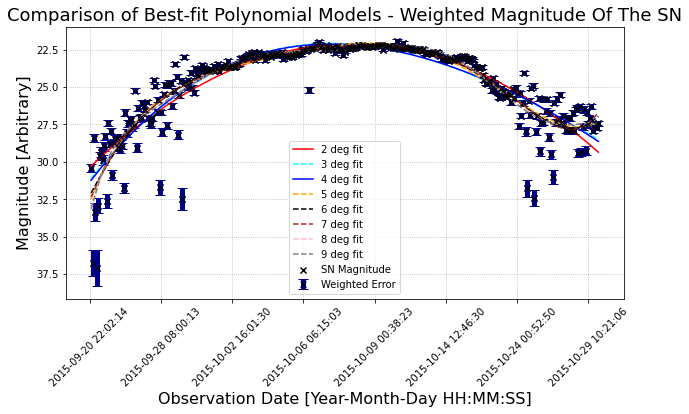

In [16]:
c = 357
x = list(np.arange(1,c+1))

#fit polynomial models up to degree 5
model1 = np.poly1d(np.polyfit(x, sn_mag_wmean, 1))
model2 = np.poly1d(np.polyfit(x, sn_mag_wmean, 2))
model3 = np.poly1d(np.polyfit(x, sn_mag_wmean, 3))
model4 = np.poly1d(np.polyfit(x, sn_mag_wmean, 4))
model5 = np.poly1d(np.polyfit(x, sn_mag_wmean, 5))
model6 = np.poly1d(np.polyfit(x, sn_mag_wmean, 6))
model7 = np.poly1d(np.polyfit(x, sn_mag_wmean, 7))
model8 = np.poly1d(np.polyfit(x, sn_mag_wmean, 8))
model9 = np.poly1d(np.polyfit(x, sn_mag_wmean, 9))

plt.figure(figsize = (10,5))

#create scatterplot
polyline = np.linspace(1, c, 50)
plt.scatter(x, sn_mag_wmean, color='black', marker='x', label='SN Magnitude')
plt.errorbar(x, sn_mag_wmean, yerr = sn_mag_wmean_std, fmt='x', color='black', ecolor='darkblue', elinewidth=5, capsize=5, label='Weighted Error')

#add fitted polynomial lines to scatterplot 
#plt.plot(polyline, model1(polyline), color='green', linestyle='dashed', label='1 deg fit')
plt.plot(polyline, model2(polyline), color='red', label='2 deg fit')
plt.plot(polyline, model3(polyline), color='cyan', linestyle='dashed', label='3 deg fit')
plt.plot(polyline, model4(polyline), color='blue', label='4 deg fit')
plt.plot(polyline, model5(polyline), color='orange', linestyle='dashed', label='5 deg fit')
plt.plot(polyline, model6(polyline), color='black', linestyle='dashed', label='6 deg fit')
plt.plot(polyline, model7(polyline), color='brown', linestyle='dashed', label='7 deg fit')
plt.plot(polyline, model8(polyline), color='pink', linestyle='dashed', label='8 deg fit')
plt.plot(polyline, model9(polyline), color='gray', linestyle='dashed', label='9 deg fit')

#plt.scatter(good_file_times, sn_mag_wmean, label='Mag w mean of all Ref Stars')
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(sn_mag1)+1, 50))
plt.gca().invert_yaxis()
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Magnitude [Arbitrary]", size = 16)
plt.title("Comparison of Best-fit Polynomial Models - Weighted Magnitude Of The SN", size = 18)
plt.legend()
plt.savefig('Lab3_SNMagBestfits' + '.png', bbox_inches='tight', dpi=400)
plt.show()

Max value: 22.12656198948935 , on: 2015-10-08 05:01:12


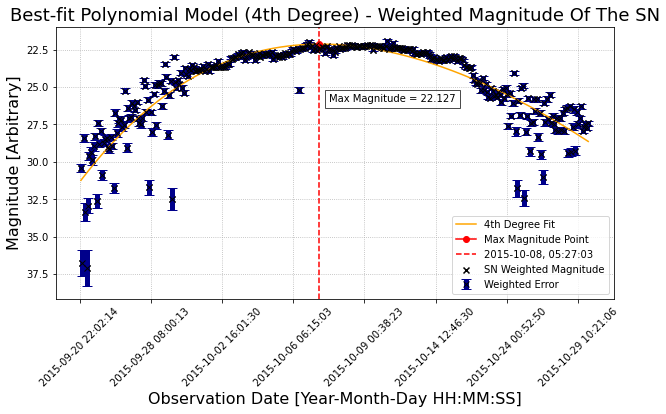

In [17]:
#finding the max of the best fit line
#best-fit = 4 deg fit

c = 357
x = list(np.arange(1,c+1))

#fit polynomial models up to degree 5
model4 = np.poly1d(np.polyfit(x, sn_mag_wmean, 4))

plt.figure(figsize = (10,5))

#create scatterplot
polyline = np.linspace(1, c, 357)
plt.scatter(x, sn_mag_wmean, color='black', marker='x', label='SN Weighted Magnitude')
plt.errorbar(x, sn_mag_wmean, yerr = sn_mag_wmean_std, fmt='x', color='black', ecolor='darkblue', elinewidth=5, capsize=5, label='Weighted Error')

#add fitted polynomial lines to scatterplot 
#plt.plot(polyline, model1(polyline), color='green', linestyle='dashed', label='1 deg fit')
plt.plot(polyline, model4(polyline), color='orange', label='4th Degree Fit')

n = np.min(model4(polyline))
m = np.where(model4(polyline) == n)[0][0]
date_max = good_file_times[np.where(model4(polyline) == n)][0]
plt.plot(m, n, color='red', marker='o', label='Max Magnitude Point')
print('Max value:', n, ', on:', date_max)
plt.axvline(x=m, color = 'r', linestyle='dashed', label = '2015-10-08, 05:27:03')

#plt.scatter(good_file_times, sn_mag_wmean, label='Mag w mean of all Ref Stars')
plt.xticks(np.arange(len(good_file_times)), good_file_times, rotation=45)
plt.xticks(np.arange(0, len(sn_mag1)+1, 50))
plt.gca().invert_yaxis()
plt.grid(linestyle='dotted')
plt.xlabel('Observation Date [Year-Month-Day HH:MM:SS]', size = 16)
plt.ylabel("Magnitude [Arbitrary]", size = 16)
plt.title("Best-fit Polynomial Model (4th Degree) - Weighted Magnitude Of The SN", size = 18)
plt.text(175, 26, "Max Magnitude = {:.3f}".format(n), fontdict=dict(fontsize=10), bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
plt.legend()
plt.savefig('Lab3_SNMagBestfitMax' + '.png', bbox_inches='tight', dpi=400)
plt.show()

SN max flux: 8167.705755251156 on: 2015-10-10 20:35:09


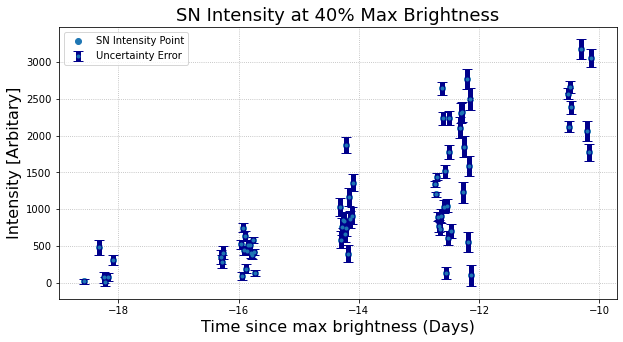

In [18]:
#Finding the first Epoch
sn_max_flux_ind = int(np.where(sn_phot_fixed == np.max(sn_phot_fixed))[0])
file_sn_max_flux = good_files[sn_max_flux_ind]
date_sn_max_flux = good_file_times[sn_max_flux_ind]
time_from_max = [(time - good_file_times[sn_max_flux_ind]).total_seconds()/86400 for time in good_file_times]
print('SN max flux:', sn_phot_fixed[sn_max_flux_ind], 'on:', date_sn_max_flux)

#Power law fit to data
sn_phot_fixed_sliced = sn_phot_fixed[:sn_max_flux_ind]
lim40idx = np.where(sn_phot_fixed_sliced <= (sn_phot_fixed.max()*0.4))
sn40idx, file_times40 = sn_phot_fixed[lim40idx[0]][1:-2], np.array(time_from_max)[lim40idx[0]][1:-2]
sn40idx_std = sn_phot_std_fixed[lim40idx[0]][1:-2]

plt.figure(figsize = (10,5))
plt.scatter(file_times40, sn40idx, label='SN Intensity Point')
plt.errorbar(file_times40, sn40idx, yerr = sn40idx_std, fmt='.', ecolor='darkblue', elinewidth=5, capsize=5, label='Uncertainty Error')
plt.grid(linestyle='dotted')
plt.xlabel('Time since max brightness (Days)', size=16)
plt.ylabel('Intensity [Arbitary]', size=16)
plt.title('SN Intensity at 40% Max Brightness', size=18)
plt.legend()
plt.savefig('Lab3_SNMaxIntensity-days' + '.png', bbox_inches='tight', dpi=400)
plt.show()

C: 53.64757089315671 ± 10.8516190058094
t1: -17.499999999999996 ± 0.5656888902638737


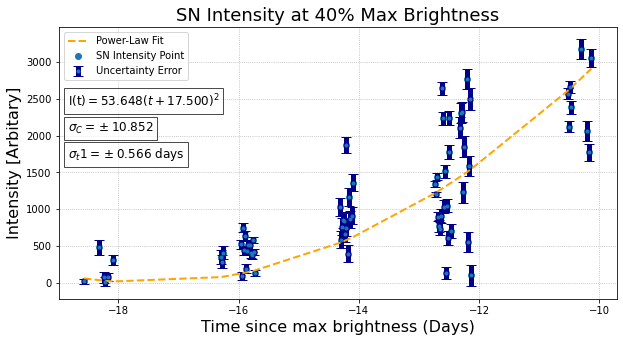

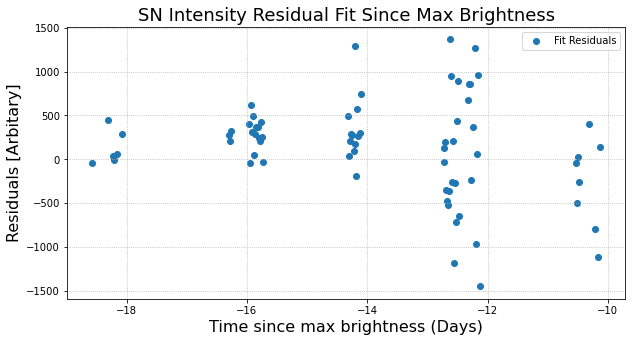

In [19]:
#power-law fitting to the early part of the light curve to estimate its epoch of first light.
def power_law_fit(t, c, t1):
    """
    Supernova Brightness power law: I(t)=c(t-t1)**2 (from lecture)
    """
    return c*(t-t1)**2

pars, cov = curve_fit(f=power_law_fit, xdata=file_times40, ydata=sn40idx, bounds=((-np.inf, -17.5), (np.inf, -10)))
pars_stdev = np.sqrt(np.diag(cov)) 
residuals = sn40idx-power_law_fit(file_times40, *pars)

print('C:', pars[0], '±', pars_stdev[0])
print('t1:', pars[1], '±', pars_stdev[1])

plt.figure(figsize = (10,5))
plt.grid(linestyle='dotted')
plt.scatter(file_times40, sn40idx, label='SN Intensity Point')
plt.errorbar(file_times40, sn40idx, yerr = sn40idx_std, fmt='.', ecolor='darkblue', elinewidth=5, capsize=5, label='Uncertainty Error')
plt.plot(file_times40, power_law_fit(file_times40, *pars), label='Power-Law Fit', linestyle='--', linewidth=2, color='orange')
plt.xlabel('Time since max brightness (Days)', size=16)
plt.ylabel('Intensity [Arbitary]', size=16)
plt.title('SN Intensity at 40% Max Brightness', size=18)
plt.text(-18.84, 2400, "I(t)$ = {:.3f} (t + {:.3f})^2$".format(pars[0], np.abs(pars[1])), fontdict=dict(fontsize=12), bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
plt.text(-18.84, 2050, "$\sigma_C = \pm{:.3f}$".format(pars_stdev[0]), fontdict=dict(fontsize=12), bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
plt.text(-18.84, 1700, "$\sigma_t1 = \pm{:.3f}$ days".format(pars_stdev[1]), fontdict=dict(fontsize=12), bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
plt.legend()
plt.savefig('Lab3_SNMaxIntensity_Powerlawfit' + '.png', bbox_inches='tight', dpi=400)
plt.show()


plt.figure(figsize = (10,5))
plt.scatter(file_times40, residuals, label='Fit Residuals')
plt.grid(linestyle='dotted')
plt.xlabel('Time since max brightness (Days)', size=16)
plt.ylabel('Residuals [Arbitary]', size=16)
plt.title('SN Intensity Residual Fit Since Max Brightness', size=18)
plt.legend()
plt.savefig('Lab3_SNMaxIntensity-ResidualFit' + '.png', bbox_inches='tight', dpi=400)
plt.show()

**Minimum Chi-Square (Best-Fit) Parameter Estimation**

In [53]:
def chisquare(model, obs, err):
    return np.sum(((obs-model)/err)**2)

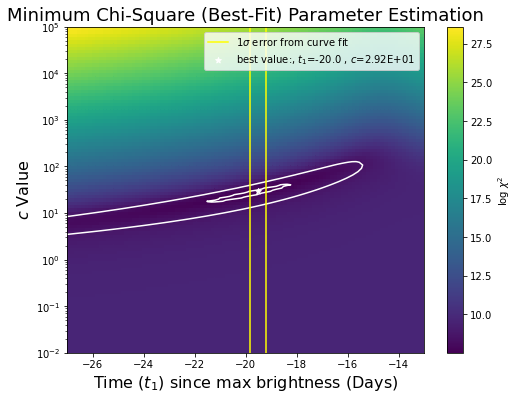

In [69]:
chi_squares = np.zeros([100,100])
test_1s = np.zeros([100,100])
test_cs = np.zeros([100,100])
for i, test_t_1 in enumerate(np.linspace(-27,-13,100)):
    for j, test_c in enumerate(np.logspace(-2, 5,100)):
        test_1s[i,j] = test_t_1
        test_cs[i,j] = test_c
        chi_squares[i,j] = chisquare(model=power_law_fit(file_times40, test_c, test_t_1), obs=sn40idx, err=sn40idx_std)       

plt.figure(figsize=(8,6))
plt.pcolormesh(test_1s, test_cs, np.log(chi_squares))
plt.yscale('log')
plt.ylabel('$c$ Value', size=16)
plt.xlabel('Time ($t_1$) since max brightness (Days)', size=16)
plt.title('Minimum Chi-Square (Best-Fit) Parameter Estimation', size=18)
plt.colorbar(label='log $\chi^2$')
plt.contour(test_1s, test_cs, np.log(chi_squares), [ np.log(np.percentile(chi_squares,0.3)),np.log(np.percentile(chi_squares,5))],colors='white',)
plt.scatter(test_1s[np.unravel_index(chi_squares.argmin(), chi_squares.shape)],
            test_cs[np.unravel_index(chi_squares.argmin(), chi_squares.shape)],
           marker = '*',
           color='white',
           label='best value:, $t_1$=' 
            + str(np.round(test_1s[np.unravel_index(chi_squares.argmin(), chi_squares.shape)]))
           + ' , $c$=' +'%.2E' % Decimal(str(test_cs[np.unravel_index(chi_squares.argmin(), chi_squares.shape)]))) 
#fmt = {}
plt.axvline(test_1s[np.unravel_index(chi_squares.argmin(), chi_squares.shape)]+cov[1,1], color='yellow', label='1$\sigma$ error from curve fit')
plt.axvline(test_1s[np.unravel_index(chi_squares.argmin(), chi_squares.shape)]-cov[1,1], color='yellow')
plt.legend()
plt.savefig('Lab3_SN_Chi-Square_fit' + '.png', bbox_inches='tight', dpi=400)
plt.show()

In [62]:
#reduced chi-square
chi_squares.min()/len(file_times40)

25.69921069628337